In [1]:
import numpy as np
import sys
sys.path.append('../../pysimARG')
from clonal_genealogy import ClonalTree
from ClonalOrigin_nodes import ClonalOrigin_nodes
import ClonalOrigin_pair
import clonal_genealogy
import matplotlib.pyplot as plt
import seaborn as sns
import json

## Check inputs

In [2]:
tree1 = ClonalTree(n=5)

In [3]:
print(tree1)

ClonalTree(n=5)


In [4]:
tree1.edge

array([[6.        , 2.        , 0.10949022],
       [6.        , 4.        , 0.10949022],
       [7.        , 5.        , 0.14830995],
       [7.        , 3.        , 0.14830995],
       [8.        , 6.        , 0.7063423 ],
       [8.        , 7.        , 0.66752256],
       [9.        , 1.        , 1.72280524],
       [9.        , 8.        , 0.90697273]])

In [5]:
tree1.node_height

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.10949022, 0.14830995, 0.81583251, 1.72280524])

## Fix inputs

In [6]:
n = 5
clonal_edge = np.array([
    [6,     1, 0.04401874],
    [6,     4, 0.04401874],
    [7,     2, 0.16070566],
    [7,     5, 0.16070566],
    [8,     7, 0.29958550],
    [8,     3, 0.46029115],
    [9,     6, 1.04846976],
    [9,     8, 0.63219735]
])
clonal_node_height = np.array([0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.04401874, 0.16070566, 0.46029115, 1.09248850])

In [7]:
rho_site = 0.5
L = 100
rho = L * rho_site
delta = 5.0
k = 20

## Check part 1

In [8]:
# Tree length
tree_length = np.sum(clonal_edge[:, 2])

# Initialize recombination edges
nrow_max = 1000
# Columns: b_edge, b_height, a_edge, a_height, x, y
recomb_edge = np.full((nrow_max, 6), np.nan)

# Add recombination sequentially
n_recomb = 0
remain_index = np.array([], dtype=int)

In [9]:
for i in range(1, 3):  # i = 1, 2
    if i == 1:
        R_new = np.random.poisson(rho_site * delta * tree_length / 2)
        R_old = 0
        # print(R_new)
    else:  # i == 2
        survive_index = np.where(recomb_edge[:n_recomb, 5] == 1)[0] if n_recomb > 0 else np.array([], dtype=int)
        delta2 = np.sum((1 - 1/delta) ** np.arange(k))
        R_new = np.random.poisson(rho_site * delta2 * tree_length / 2)
        # print(R_new)
        R_old = np.random.binomial(len(survive_index), (1 - 1/delta) ** k)
        remain_index = np.random.choice(survive_index, R_old, replace=False)
    
    if R_new > 0:
        # Expand matrix if needed
        if n_recomb + R_new >= nrow_max:
            recomb_edge = np.vstack([recomb_edge, np.full((nrow_max, 6), np.nan)])
            nrow_max = 2 * nrow_max
        
        # Set x and y columns
        recomb_edge[n_recomb:n_recomb + R_new, 4] = i  # x
        recomb_edge[n_recomb:n_recomb + R_new, 5] = i  # y
        
        a_rexp = np.random.exponential(1.0, size=R_new)
        
        # Simulate b_edge (similar to mutation)
        # Sample edges with probability proportional to edge length
        edge_probs = clonal_edge[:, 2] / np.sum(clonal_edge[:, 2])
        recomb_edge[n_recomb:n_recomb + R_new, 0] = np.random.choice(
            range(1, (2*n-1)), R_new, replace=True, p=edge_probs
        )
        
        for j in range(R_new):
            idx = n_recomb + j
            b_edge_idx = int(recomb_edge[idx, 0]) - 1
            
            # Simulate b_height
            recomb_edge[idx, 1] = (
                np.random.uniform(0, clonal_edge[b_edge_idx, 2]) +
                clonal_node_height[int(clonal_edge[b_edge_idx, 1])-1]
            )
            
            # Identify a_height
            # t_above_b: heights of internal nodes minus b_height
            t_above_b = clonal_node_height[n:2*n-1] - recomb_edge[idx, 1]
            
            # Get positive values (nodes above b)
            positive_mask = t_above_b >= 0
            positive_t = t_above_b[positive_mask]
            
            # i_above_b with 0 prepended
            i_above_b_full = np.concatenate([[0], np.sort(positive_t)])
            i_above_b = np.diff(i_above_b_full)
            
            # Calculate cumulative values
            num_intervals = len(i_above_b)
            lineage_counts = np.arange(num_intervals + 1, 1, -1)
            cuml_above_b = np.cumsum(i_above_b * lineage_counts)
            
            # Determine number of lineages at coalescence time
            num_lineage = (num_intervals + 1) - np.sum(a_rexp[j] > cuml_above_b)
            
            if num_lineage == (num_intervals + 1):
                recomb_edge[idx, 3] = a_rexp[j] / num_lineage + recomb_edge[idx, 1]
            else:
                idx_cuml = num_intervals - num_lineage
                recomb_edge[idx, 3] = (
                    (a_rexp[j] - cuml_above_b[idx_cuml]) / num_lineage +
                    np.sum(i_above_b[:idx_cuml + 1]) +
                    recomb_edge[idx, 1]
                )
            
            # Simulate a_edge
            if num_lineage > 1:
                a_height = recomb_edge[idx, 3]
                # Find edges that span the a_height
                pool_edge = np.where(
                    (clonal_node_height[clonal_edge[:, 0].astype(int)-1] >= a_height) &
                    (clonal_node_height[clonal_edge[:, 1].astype(int)-1] < a_height)
                )[0] + 1
                recomb_edge[idx, 2] = np.random.choice(pool_edge)
            else:
                # Root edge (using edge index 2*n-2 for 0-indexed)
                recomb_edge[idx, 2] = 2 * n - 1
    
    if R_old > 0 and len(remain_index) > 0:
        recomb_edge[remain_index, 5] = i
    
    n_recomb = n_recomb + R_new

# Handle case with no recombination
if n_recomb == 0:
    edge = clonal_edge
    edge_mat = np.full((2 * (n - 1), 2), True)
    node_height = clonal_node_height
    node_mat = np.full((2 * n - 1, 2), True)
    node_clonal = np.full(2 * n - 1, True)
    sum_time = np.max(clonal_node_height)

# Trim recomb_edge to actual size
recomb_edge = recomb_edge[:n_recomb, :]

In [10]:
n_recomb

8

In [11]:
recomb_edge.shape

(8, 6)

## Fix part 2 input

In [12]:
recomb_edge = np.array([
      [7, 0.15278785,      5, 0.40878388, 1, 1],
      [6, 0.29305188,      7, 0.30099228, 1, 2],
      [7, 0.81639045,      9, 2.26020305, 1, 1],
      [7, 0.98681554,      7, 1.05353480, 1, 1],
      [6, 0.37760004,      8, 0.66211818, 1, 1],
      [6, 0.15835553,      6, 0.37077268, 2, 2],
      [8, 0.64277796,      8, 1.03309832, 2, 2],
      [7, 1.03492990,      9, 2.36906052, 2, 2],
      [5, 0.37718232,      5, 0.40316850, 2, 2],
      [3, 0.01071185,      4, 0.13974436, 2, 2],
      [7, 0.58069071,      7, 0.59718387, 2, 2],
      [4, 0.08644245,      6, 0.09518944, 2, 2],
      [3, 0.15012588,      5, 0.40965313, 2, 2]
])

In [13]:
recomb_edge.shape

(13, 6)

In [14]:
n_recomb = 13

## Check part 2 and `ClonalOrigin_nodes`

check `node_max`, `edge_max`, `edge_matrix`, `edge_mat_index`, `node_mat`, `node_info`, `recomb_node`

In [15]:
# Build full ARG
node_max = 2 * n - 1 + 3 * n_recomb
edge_max = 2 * (n - 1) + 4 * n_recomb

edge_matrix = np.full((edge_max, 3), np.nan)
edge_mat_index = np.full(edge_max, np.nan)
node_mat = np.full((node_max, 2), np.nan)
node_info = np.full((node_max, 4), np.nan)
# Columns: index, height, recomb, clonal

node_mat[:n, :] = True
node_info[:, 0] = np.arange(1, node_max + 1)

# Set clonal node info
node_info[:2*n-1, 1] = clonal_node_height
node_info[:2*n-1, 2] = 0
node_info[:2*n-1, 3] = 1  # True -> 1

# Set recombination out nodes (b nodes)
# Interleave: for each recomb event, add two nodes at b_height
for r in range(n_recomb):
    base_idx = 2 * n - 1 + 2 * r
    node_info[base_idx, 1] = recomb_edge[r, 1]      # b_height
    node_info[base_idx, 2] = -(r + 1)               # negative recomb index (1-indexed)
    node_info[base_idx, 3] = 1                      # clonal = True
    
    node_info[base_idx + 1, 1] = recomb_edge[r, 1]  # same b_height
    node_info[base_idx + 1, 2] = np.nan             # NA
    node_info[base_idx + 1, 3] = 0                  # clonal = False

# Set recombination in nodes (a nodes)
for r in range(n_recomb):
    idx = 2 * n - 1 + 2 * n_recomb + r
    node_info[idx, 1] = recomb_edge[r, 3]           # a_height
    node_info[idx, 2] = r + 1                       # positive recomb index (1-indexed)
    node_info[idx, 3] = 1                           # clonal = True

In [16]:
# Sort by height
sort_order = np.lexsort((node_info[:, 0], node_info[:, 1]))
node_info = node_info[sort_order, :]

# Recombination nodes on every edge
# Use 1-indexed edge indices to match R behavior
recomb_node = []
for edge_idx in range(1, 2 * n):
    # Convert to 1-indexed for ClonalOrigin_nodes
    nodes = ClonalOrigin_nodes(recomb_edge, edge_idx)
    recomb_node.append(nodes)

In [17]:
node_max, edge_max

(48, 60)

In [18]:
edge_matrix.shape

(60, 3)

In [19]:
edge_mat_index.shape

(60,)

In [20]:
node_mat[:10, :]

array([[ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan]])

In [21]:
node_mat.shape

(48, 2)

In [22]:
node_info[:, 3]

array([1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1.,
       0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
       1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1.])

In [23]:
node_info.shape

(48, 4)

In [24]:
node_info

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 2.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 3.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 4.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 5.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 2.80000000e+01,  1.07118500e-02, -1.00000000e+01,
         1.00000000e+00],
       [ 2.90000000e+01,  1.07118500e-02,             nan,
         0.00000000e+00],
       [ 6.00000000e+00,  4.40187400e-02,  0.00000000e+00,
         1.00000000e+00],
       [ 3.20000000e+01,  8.64424500e-02, -1.20000000e+01,
         1.00000000e+00],
       [ 3.30000000e+01,  8.64424500e-02,             nan,
         0.00000000e+00],
       [ 4.70000000e+01,  9.51894400e-02,  1.20000000e+01,
         1.00000000e+00],
       [ 4.50000000e+01,  1.39744360e-01,  1.00000000e+01,
      

In [25]:
len(recomb_node)

9

In [26]:
recomb_node

[array([], dtype=float64),
 array([], dtype=float64),
 array([-10., -13.]),
 array([-12.,  10.]),
 array([-9.,  9.,  1., 13.]),
 array([12., -6., -2.,  6., -5.]),
 array([ -1.,   2., -11.,  11.,  -3.,  -4.,  -8.,   4.]),
 array([-7.,  5.,  7.]),
 array([3., 8.])]

## Fix part 3 input
set `node_info`, `clonal_edge`, `recomb_node`, `recomb_edge`

## Check part 3
check `edge_matrix`, `node_mat`, `edge_mat_index`, `node_info`

In [27]:
# Build ARG edges and track ancestral material
i = n  # Start after leaf nodes (0-indexed)
edge_index = 0

while i < node_max:
    recomb_val = node_info[i, 2]
    
    if recomb_val == 0:
        # Clonal tree node
        node_index = int(node_info[i, 0])
        leaf_edge = np.where(clonal_edge[:, 0] == node_index)[0]
        leaf_index = np.full(2, np.nan)
        leaf_node = np.full(2, np.nan)

        for le_idx in range(2):
            le = leaf_edge[le_idx]
            if len(recomb_node[le]) > 0:
                # Target node is last element
                tar_node = recomb_node[le][-1]
                leaf_index[le_idx] = np.where(node_info[:, 2] == tar_node)[0][0]
                leaf_node[le_idx] = node_info[int(leaf_index[le_idx]), 0]
            else:
                leaf_node[le_idx] = clonal_edge[le, 1]
                leaf_index[le_idx] = np.where(node_info[:, 0] == leaf_node[le_idx])[0][0]

        # Append edges
        edge_matrix[edge_index:edge_index+2, 0] = i + 1
        edge_matrix[edge_index:edge_index+2, 1] = leaf_index + 1
        edge_matrix[edge_index:edge_index+2, 2] = node_info[i, 1] - node_info[leaf_index.astype(int), 1]
        edge_mat_index[edge_index:edge_index+2] = leaf_index + 1

        # Append root node material
        li0, li1 = int(leaf_index[0]), int(leaf_index[1])
        node_mat[i, :] = np.logical_or(
            np.nan_to_num(node_mat[li0, :], nan=0).astype(bool),
            np.nan_to_num(node_mat[li1, :], nan=0).astype(bool)
        )

        edge_index += 2
        i += 1
        
    elif recomb_val < 0:
        # Recombination edge out node
        node_index = node_info[i:i+2, 0].astype(int)
        recomb_idx = int(abs(node_info[i, 2])) - 1
        leaf_edge = int(recomb_edge[recomb_idx, 0]) - 1

        tar_node = np.where(recomb_node[leaf_edge] == node_info[i, 2])[0]
        if tar_node == 0:
            leaf_node = clonal_edge[leaf_edge, 1]
        else:
            leaf_node = node_info[np.where(recomb_node[leaf_edge][tar_node-1] == node_info[:, 2])[0][0], 0]

        leaf_index = int(np.where(node_info[:, 0] == leaf_node)[0][0])

        # Append edges
        edge_matrix[edge_index:edge_index+2, 0] = [i + 1, i + 2]
        edge_matrix[edge_index:edge_index+2, 1] = leaf_index + 1
        edge_matrix[edge_index:edge_index+2, 2] = node_info[i, 1] - node_info[leaf_index, 1]
        edge_mat_index[edge_index:edge_index+2] = [i + 1, i + 2]

        x = int(recomb_edge[recomb_idx, 4])
        y = int(recomb_edge[recomb_idx, 5])

        # Append root node material
        node_mat[i:i+2, :] = False
        # x:y in R is inclusive, in Python x-1:y is equivalent for 1-indexed to 0-indexed
        node_mat[i + 1, x-1:y] = np.nan_to_num(node_mat[leaf_index, x-1:y], nan=0).astype(bool)

        # For the complement (-(x:y) in R means all except x:y)
        mask = np.ones(2, dtype=bool)
        mask[x-1:y] = False
        node_mat[i, mask] = np.nan_to_num(node_mat[leaf_index, mask], nan=0).astype(bool)

        edge_index += 2
        i += 2
        
    elif recomb_val > 0:
        # Recombination edge in node
        node_index = int(node_info[i, 0])
        recomb_idx = int(node_info[i, 2]) - 1
        leaf_edge = int(recomb_edge[recomb_idx, 2]) - 1

        tar_node = np.where(recomb_node[leaf_edge] == node_info[i, 2])[0]
        if tar_node == 0:
            if leaf_edge== 2*n - 2:
                leaf_node = 2*n - 1
            else:
                leaf_node = clonal_edge[leaf_edge, 1]
        else:
            leaf_node = node_info[np.where(recomb_node[leaf_edge][tar_node-1] == node_info[:, 2])[0][0], 0]

        leaf_index = np.full(2, np.nan)
        leaf_index[0] = int(np.where(node_info[:, 0] == leaf_node)[0][0])
        leaf_index[1] = int(np.where(node_info[:, 2] == (-node_info[i, 2]))[0][0]) + 1

        # Append edges
        edge_matrix[edge_index:edge_index+2, 0] = i + 1
        edge_matrix[edge_index:edge_index+2, 1] = leaf_index + 1
        edge_matrix[edge_index:edge_index+2, 2] = node_info[i, 1] - node_info[leaf_index.astype(int), 1]
        edge_mat_index[edge_index:edge_index+2] = leaf_index + 1

        # Append root node material
        li0, li1 = int(leaf_index[0]), int(leaf_index[1])
        node_mat[i, :] = np.logical_or(
            np.nan_to_num(node_mat[li0, :], nan=0).astype(bool),
            np.nan_to_num(node_mat[li1, :], nan=0).astype(bool)
        )

        edge_index += 2
        i += 1
    else:
        # NaN case - skip
        i += 1

In [28]:
edge_matrix

array([[6.00000000e+00, 2.00000000e+00, 1.07118500e-02],
       [7.00000000e+00, 2.00000000e+00, 1.07118500e-02],
       [8.00000000e+00, 1.00000000e+00, 4.40187400e-02],
       [8.00000000e+00, 4.00000000e+00, 4.40187400e-02],
       [9.00000000e+00, 5.00000000e+00, 8.64424500e-02],
       [1.00000000e+01, 5.00000000e+00, 8.64424500e-02],
       [1.10000000e+01, 3.00000000e+00, 9.51894400e-02],
       [1.10000000e+01, 1.00000000e+01, 8.74699000e-03],
       [1.20000000e+01, 9.00000000e+00, 5.33019100e-02],
       [1.20000000e+01, 7.00000000e+00, 1.29032510e-01],
       [1.30000000e+01, 6.00000000e+00, 1.39414030e-01],
       [1.40000000e+01, 6.00000000e+00, 1.39414030e-01],
       [1.50000000e+01, 8.00000000e+00, 1.08769110e-01],
       [1.60000000e+01, 8.00000000e+00, 1.08769110e-01],
       [1.70000000e+01, 1.10000000e+01, 6.31660900e-02],
       [1.80000000e+01, 1.10000000e+01, 6.31660900e-02],
       [1.90000000e+01, 1.30000000e+01, 1.05797800e-02],
       [1.90000000e+01, 1.20000

In [29]:
node_mat

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 0.],
       [0., 1.],
       [1., 1.],
       [1., 0.],
       [0., 1.],
       [1., 1.],
       [1., 1.],
       [1., 0.],
       [0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 1.],
       [0., 0.],
       [1., 0.],
       [1., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 0.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 0.],
       [0., 1.],
       [1., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 0.],
       [1., 1.],
       [0., 0.],
       [0., 1.],
       [0., 0.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [30]:
edge_mat_index

array([ 6.,  7.,  1.,  4.,  9., 10.,  3., 10.,  9.,  7., 13., 14., 15.,
       16., 17., 18., 13., 12., 20., 21., 15., 21., 20., 18., 24., 25.,
       26., 27., 24., 25., 28., 16., 29., 14., 30., 26., 32., 33., 32.,
       33., 35., 36., 35., 27., 38., 39., 40., 41., 37., 36., 43., 44.,
       43., 41., 45., 42., 46., 39., 47., 44.])

In [31]:
node_info

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 2.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 3.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 4.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 5.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 2.80000000e+01,  1.07118500e-02, -1.00000000e+01,
         1.00000000e+00],
       [ 2.90000000e+01,  1.07118500e-02,             nan,
         0.00000000e+00],
       [ 6.00000000e+00,  4.40187400e-02,  0.00000000e+00,
         1.00000000e+00],
       [ 3.20000000e+01,  8.64424500e-02, -1.20000000e+01,
         1.00000000e+00],
       [ 3.30000000e+01,  8.64424500e-02,             nan,
         0.00000000e+00],
       [ 4.70000000e+01,  9.51894400e-02,  1.20000000e+01,
         1.00000000e+00],
       [ 4.50000000e+01,  1.39744360e-01,  1.00000000e+01,
      

In [32]:
edge_mat = np.array([
    [1, 0], [0, 1], [1, 1], [1, 1], [1, 0], [0, 1], [1, 1], [0, 1], [1, 0], [0, 1],
    [1, 0], [0, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 1], [0, 0], [1, 0],
    [0, 1], [1, 0], [0, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 0], [1, 0], [0, 1],
    [1, 1], [1, 0], [1, 1], [0, 0], [1, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1],
    [1, 0], [0, 1], [1, 0], [0, 0], [0, 1], [1, 0], [0, 1], [0, 0], [1, 0], [0, 1],
    [0, 0], [0, 1], [0, 0], [0, 0], [0, 0], [1, 1], [1, 1], [1, 0], [1, 1], [0, 1]
])

In [33]:
edge_mat.shape

(60, 2)

In [34]:
node_mat[edge_mat_index.astype(int) - 1, :] == edge_mat

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ Tr

## Test run

In [23]:
clonal_tree = clonal_genealogy.ClonalTree(n=10)

In [24]:
with open('../../pysimARG/test_data/tree_example.json', 'r') as f:
    tree_dict = json.load(f)

# Verify the type and content
print(type(tree_dict))  # <class 'dict'>
print(tree_dict)

<class 'dict'>
{'edge': [[11, 7, 0.0205], [11, 6, 0.0205], [12, 9, 0.1066], [12, 10, 0.1066], [13, 11, 0.093], [13, 8, 0.1135], [14, 13, 0.0963], [14, 3, 0.2099], [15, 2, 0.238], [15, 12, 0.1314], [16, 5, 0.3753], [16, 15, 0.1374], [17, 4, 0.4074], [17, 14, 0.1975], [18, 16, 0.3947], [18, 17, 0.3626], [19, 18, 1.8296], [19, 1, 2.5996]], 'node': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0205, 0.1066, 0.1135, 0.2099, 0.238, 0.3753, 0.4074, 0.77, 2.5996], 'n': 10}


In [25]:
clonal_tree.edge = np.array(tree_dict['edge'])
clonal_tree.node_height = np.array(tree_dict['node'])

In [26]:
ARG = ClonalOrigin_pair.ARG(clonal_tree, 0.5, 100, 5.0, 20)

In [27]:
length_list = []
height_list = []
np.random.seed(100)

for i in range(10000):
    ARG = ClonalOrigin_pair.ARG(clonal_tree, 0.5, 100, 5.0, 20)
    length_list.append(ARG.length)
    height_list.append(ARG.height)

    if i % 100 == 0:
        print(f'Completed {i} iterations.')

Completed 0 iterations.
Completed 100 iterations.
Completed 200 iterations.
Completed 300 iterations.
Completed 400 iterations.
Completed 500 iterations.
Completed 600 iterations.
Completed 700 iterations.
Completed 800 iterations.
Completed 900 iterations.
Completed 1000 iterations.
Completed 1100 iterations.
Completed 1200 iterations.
Completed 1300 iterations.
Completed 1400 iterations.
Completed 1500 iterations.
Completed 1600 iterations.
Completed 1700 iterations.
Completed 1800 iterations.
Completed 1900 iterations.
Completed 2000 iterations.
Completed 2100 iterations.
Completed 2200 iterations.
Completed 2300 iterations.
Completed 2400 iterations.
Completed 2500 iterations.
Completed 2600 iterations.
Completed 2700 iterations.
Completed 2800 iterations.
Completed 2900 iterations.
Completed 3000 iterations.
Completed 3100 iterations.
Completed 3200 iterations.
Completed 3300 iterations.
Completed 3400 iterations.
Completed 3500 iterations.
Completed 3600 iterations.
Completed 370

In [28]:
R_data = np.loadtxt('../../pysimARG/test_data/ARG_length_height.csv', delimiter=",", skiprows=1)
R_data # length, height

array([[19.50490685,  4.14143605],
       [20.92397307,  4.20359539],
       [20.12720209,  4.21323096],
       ...,
       [14.17295352,  2.73046148],
       [26.75294165,  6.97592099],
       [29.08233763,  6.16520568]], shape=(10000, 2))

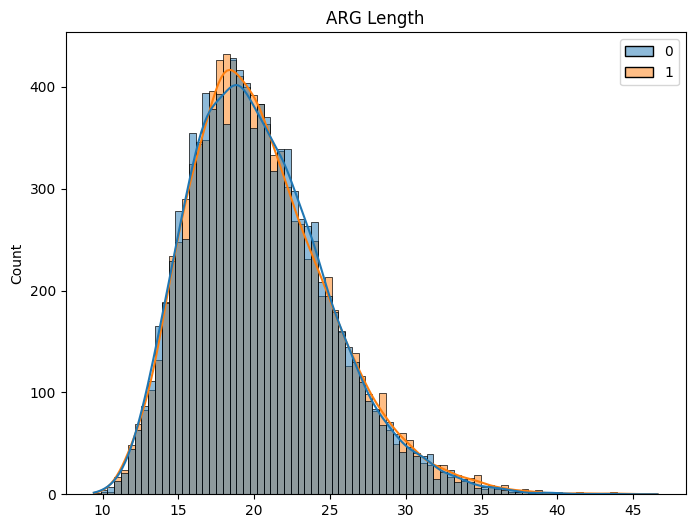

In [32]:
plt.figure(figsize=(8, 6))

# You can pass data directly as a list of arrays
sns.histplot([length_list, R_data[:, 0]], kde=True) 

# Note: kde=True adds the smooth density line on top
plt.title('ARG Length')
plt.show()

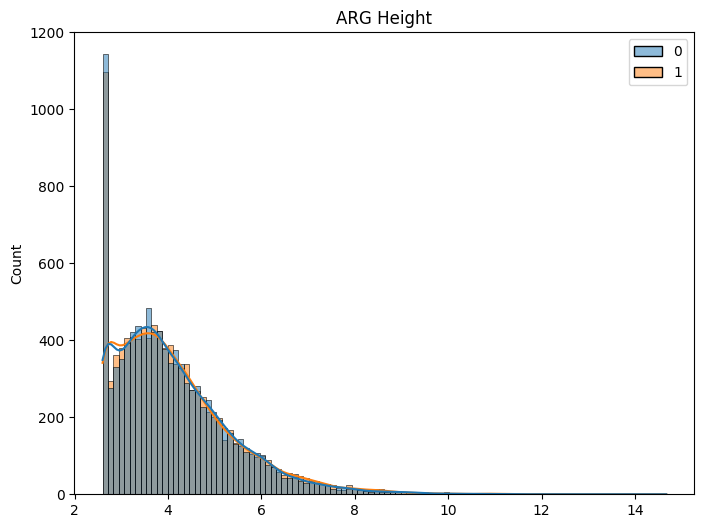

In [31]:
plt.figure(figsize=(8, 6))

# You can pass data directly as a list of arrays
sns.histplot([height_list, R_data[:, 1]], kde=True) 

# Note: kde=True adds the smooth density line on top
plt.title('ARG Height')
plt.show()

In [9]:
survive_index = np.array([0])
np.random.choice(survive_index, 0, replace=False)

array([], dtype=int64)

In [13]:
list1 = list(range(10))

In [16]:
list1[:0] == 1

False